# Задача Б: поиск фейковых отзывов

Отзывы на Wildberries — вид обратной связи, которую можно оставить только после заказа товара. Отзывы отображаются в карточке товара (см. рис.) и отражаются в виде рейтинга товара в звездах с текстовым комментарием.

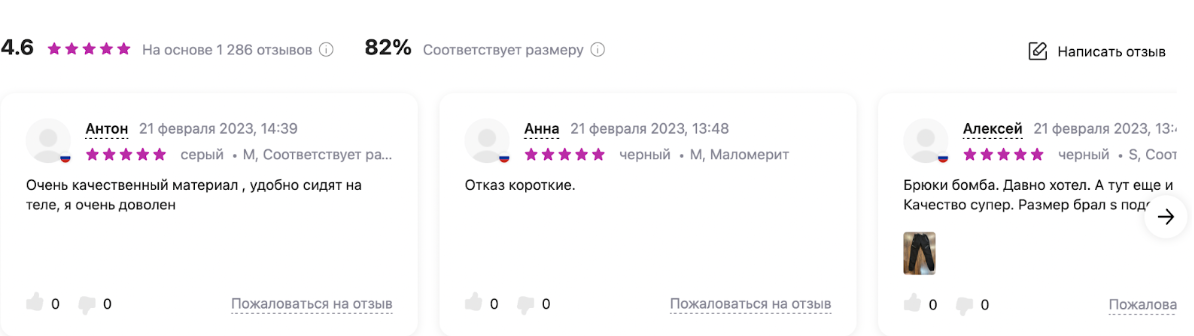
#### Задача
Необходимо разработать механизм, позволяющий определить фейковые отзывы. Фейковый отзыв — проплаченный, нечестно мотивированный отзыв с целью повлиять на рейтинг товара. 
Существует два вида таких отзывов: 
положительный отзыв написан для поставщика, который заказал себе этот отзыв; 
отрицательный отзыв написан для другого поставщика с целью снизить рейтинг товара.
#### Данные
Предоставляем список размеченных отзывов, со всей необходимой мета-информацией формате csv (пользователь, текст отзыва, оценка, является ли фейком)
#### Результат
Итогом работы должен стать набор скриптов, который позволяет по полученному на входе отзыву получить ответ, является отзыв фейковым, а также сформированная выдача для тестовых отзывов.


## <u>Этап 1.</u> Проработка и формализация задачи, определение таргета

Задача состоит в том, чтобы определить является отзыв фейковым или нет, эта задача NLP (Natural language processing) является задачей классификации обучения с учителем, так как нам заранее даны метки label. Отзывы в данном случае являются объектами, а id и текст отзыва - признаками. <b>Таргет</b> определяется как Y = {0, 1}, либо как вероятность события, что отзыв окажется фейковым (например, для модели логистической регрессии) с дальнейшим округлением.

Попробуем взглянуть на данные для формализации задачи.

Для этого импортируем все необходимые модули, считываем данные, а после выводим первые 5 строк

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('wb_school_task_2.csv.gzip', compression='gzip')

In [4]:
df.head()

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0


Таким образом, в качестве <b>входных данных</b> имеются:

* `id1` - id пользователя

* `id2` - id

* `id3` - id товара

* `text` - текст отзыва

* `f1`, ... , `f8` - неизвестные фичи

<b>Результатом решения</b> должна быть модель, которая по входным данным прогнозирует `label`.

<b>Ход решения:</b>

* Предобработка данных.

* Извлечение дополнительных признаков из текста, влияющих на "фейковость", например можно для каждого пользователя посмотреть писал ли он раньше фейковые отзывы, или, например, проанализировать текст на речевые приемы, присущие только фейковым отзывам. Так же стоит посмотреть на то, какой род использует пользователь, если раньше был мужской, а теперь женский, то это говорит о фейковости.

* Изучение статей/способов решения данной задачи.

* Выбор модели, обучение на тренировочных данных и оценка на тестовых.

* Доработка модели.

## <u>Этап 2.</u> Первичный анализ данных, очищение данных

Посмотрим на сводную статистику по данным и на типы каждого из столбцов

In [5]:
display(df.describe())
df.info();

,id1,id2,id3,f1,f2,f3,f4,f5,f6,f7,f8,label
count,3.123000e+03,3.123000e+03,3.123000e+03,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000
mean,9.129430e+18,9.227826e+18,9.372505e+18,19.409862,16.216459,4.232658,808.603586,216.628562,4.453445,48.155620,94.356708,0.264169
std,5.355614e+18,5.337195e+18,5.328720e+18,35.746560,26.070112,1.179999,2509.350075,802.154201,0.619495,67.107753,329.525613,0.440960
min,1.761133e+16,5.008190e+15,2.716666e+16,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,4.528846e+18,4.499907e+18,4.713547e+18,2.000000,2.000000,4.076923,26.000000,6.000000,4.331071,8.000000,13.000000,0.000000
50%,9.018343e+18,9.283218e+18,9.120257e+18,8.000000,7.000000,4.764706,116.000000,26.000000,4.617978,30.000000,45.000000,0.000000
75%,1.378798e+19,1.376912e+19,1.395917e+19,23.000000,20.000000,5.000000,493.000000,110.000000,4.809556,65.000000,107.000000,1.000000
max,1.844348e+19,1.844196e+19,1.844430e+19,638.000000,550.000000,5.000000,35375.000000,15683.000000,5.000000,1058.000000,9243.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id1     3123 non-null   uint64 
 1   id2     3123 non-null   uint64 
 2   id3     3123 non-null   uint64 
 3   text    3123 non-null   object 
 4   f1      3123 non-null   int64  
 5   f2      3123 non-null   int64  
 6   f3      3123 non-null   float64
 7   f4      3123 non-null   int64  
 8   f5      3123 non-null   int64  
 9   f6      3123 non-null   float64
 10  f7      3123 non-null   int64  
 11  f8      3123 non-null   int64  
 12  label   3123 non-null   int64  
dtypes: float64(2), int64(7), object(1), uint64(3)
memory usage: 317.3+ KB


Как видим, все данные приведены в нужный формат, параметр `text` имеет тип <i>object</i>, так как в нем находятся данные типа <i>string</i>.

Проверим есть ли пропуски в данных.

In [6]:
df.isnull().sum()

id1      0
id2      0
id3      0
text     0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64

Пропусков нет, проверим `text` на нулевые строки и явные дубликаты.

In [7]:
df[df['text'].apply(lambda x: len(x) < 10)]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
637,14533498944280804100,11860455876991826814,15053676552810216566,👍👍👍👍👍👍,13,13,4.846154,881,175,4.611805,84,127,0
881,6343338495020726777,6439350116378486745,3299377274227172733,Сладкое.👍,36,35,5.000000,131,26,4.236641,69,81,0
1013,8796803553608310886,2200666915301137698,8223254633971568382,чехол топ,1,1,5.000000,8,5,5.000000,20,24,0
1218,18020901957991569865,11775626371433002033,17776117386538683712,👌👍🏼👍🏼👍🏼👍🏼,6,6,5.000000,17,1,4.235294,9,14,0
1578,7481323717630919604,1193024390702574618,4678817758517429044,всё супер,21,19,4.619048,566,74,4.821555,78,90,0
1691,11858891068696899872,16133019917311179547,14780422572650268373,Отлично 👌,11,10,4.727273,331,21,4.628399,19,41,0
1849,3243712203870658563,18082468239459887307,890575200763349340,Суперский,22,22,4.909091,6290,2789,4.615103,35,46,0
1894,5861015696767814501,3109216944255490721,16971984002957170945,Супер!👍👍,2,2,5.000000,632,30,4.914557,15,18,0
2467,10850949862064835067,2227436679703386069,16469480842499997014,Огонь🔥🔥🔥,10,10,4.600000,809,487,4.761434,109,207,0
2599,3338297114409933453,12127127076018749799,8223254633971568382,Классный!,2,2,3.000000,162,91,4.888889,99,143,0


In [8]:
df[df['text'].duplicated()].sort_values('text').tail(10)

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
1879,16940840997520901723,8521446954447038315,18087129206212492216,Соответствует описанию,26,25,4.807692,1200,166,4.743333,108,128,0
2066,2930104278371077583,1916848567433408667,16301875644809960327,Соответствует описанию,25,22,4.640000,12,4,4.166667,33,77,0
2447,3750611452702684267,9680132417781805241,10806335763394378809,Спасибо большое,7,7,5.000000,17948,3285,4.478493,11,12,1
2958,16218428115977586723,13301748120188946040,12804658456659196855,Спасибо большое,1,1,5.000000,154,31,4.824675,1,1,0
2651,17227261127548079281,9207133839057275882,9219517891581373141,Товар соответствует описанию,57,47,4.982456,401,59,4.763092,82,90,0
2754,2564958524981139600,1985994406404683453,8223254633971568382,Товар соответствует описанию,2,2,5.000000,14,0,5.000000,2,5,0
2752,10735469325551462115,16174813220852916312,10023277565824975246,Товар соответствует описанию,19,19,5.000000,116,39,4.698276,20,25,0
1401,15472897685955344766,16057343414778564269,17583253655619687175,Хорошее качество,9,9,5.000000,6,3,5.000000,44,45,0
1359,13342614662927699084,7514162619400475035,17799864575663920578,Хороший товар,27,26,3.851852,250,42,4.488000,35,44,0
1749,4014539840590851792,13652358729751039169,12341791355442600237,Хороший товар,5,5,5.000000,1340,398,4.701493,7,7,1


Можно заметить, что при идентичных текстах результат может различаться. Это, видимо, зависит от id. Так как f{i} параметры при этом тоже не одинаковые, то можно сделать вывод, что в них это учитывается.

Посмотрим на матрицу корреляции, чтобы найти зависимости между параметрами и целевой функцией.

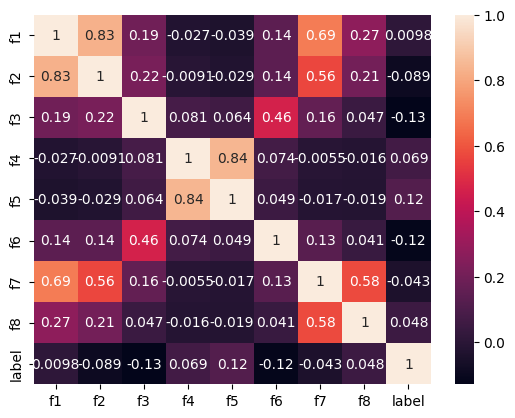

In [9]:
corr = df[['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'label']].corr()
sns.heatmap(corr, annot=True);

In [14]:
for col in df.columns[4:-1]:
    plt.scatter(x=s)

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8'], dtype='object')

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [94]:
X = df[['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [131]:
model = LogisticRegression(n_jobs=10)
model.fit(X_train, y_train)
pred = model.predict(X_test)
model.score(X_test, y_test)

0.7516005121638925